In [1]:
using Plots

In [2]:
function display_position(pos_matrix, cars, num_lanes, time, stop)
    street = []
    for _ in 1:num_lanes
        lane = collect("-" ^ stop)
        lane[stop] = '|'
        lane[stop-30] = '|'
        push!(street, lane)
    end
    
    for c in 1:length(cars)
        lane = street[cars[c][2]]
        lane[pos_matrix[c, time]] = Char('0' + c)
    end
    
    for l in street
        println(join(l))
    end
end

display_position (generic function with 1 method)

In [3]:
function make_cars(num_cars)
    car = [-1, 1, 1, 1, false]                          # start lead car at pos = -1
    cars = [car]
    for _ in 1:num_cars-1
        car = []
        arrived = false                                 # car passed dest?
        speed = rand(1:5)                               # randomize speed    
        spacing = rand(2:7)                             # randomize spacing
        lane = 1                                        # all cars start in lane 1
        pos = cars[end][1] - 1 - spacing - rand(1:5)    # next car trails the previous car by spacing + some random amount
        car = [pos, lane, spacing, speed, arrived]
        push!(cars, car)
    end

    pos_of_last_car = cars[end][1]                      # get pos of last car
    shift_pos = 1 - pos_of_last_car
    for car in cars
        car[1] += shift_pos                             # shift pos, last car starts at pos = 1
    end
    
    return cars
end

make_cars (generic function with 1 method)

In [4]:
function reset_cars!(cars)
    
    cars[1][1] = -1                          # reset pos
    cars[1][2] = 1                           # reset lane
    cars[1][5] = false                       # reset arrived
    
    for c in 2:length(cars)
        car = cars[c]
        car[1] = cars[c-1][1] - 1 - car[3]   # reset pos
        car[2] = 1                           # reset lane
        car[5] = false                       # reset arrived
    end
    
    pos_last_car = cars[end][1]              # get pos of last car
    shift_pos = 1 - pos_last_car
    for car in cars
        car[1] += shift_pos                  # shift pos, last car starts at pos = 1
    end
    
end

reset_cars! (generic function with 1 method)

In [5]:
function simulate_traffic(cars, num_lanes, dest, time)
    
    num_cars = length(cars)
    dest += cars[1][1]
    
    # Simulate Traffic
    pos_matrix = zeros(Int, num_cars, time)                             # save pos of cars over time
    stop = dest + num_cars*9                                            # cars will stop at this distance
                                                                        
    for c in 1:num_cars
        pos_matrix[c, 1] = cars[c][1]                                   # t = 1
    end

    #println("t = 1")
    #display_position(pos_matrix, cars, num_lanes, 1, stop)
    #println()
    
    total_lane_switches = 0
    arrival_times = zeros(Int, num_cars)
    for t in 2:time
        #println("t = ", t)
        for car_id in 1:length(cars)
            car = cars[car_id]
            speed = car[4]

            move = true

            for j in 1:length(cars)
                other_car = cars[j]
                dist = other_car[1] - car[1]
                if dist > 0                                            # check if car is in front
                    if (dist - speed) <= car[3]                        # if car is closer than (spacing + speed) car does not move
                        if other_car[2] == car[2]                      # check if car is in same lane

                            switch_down = true
                            if car[2] <= 1
                                switch_down = false
                            end
                            for c in cars
                            #   if other_car is in next lane AND is within + OR - 1 of curr_car pos: switch_lane = false
                                if c[2] == car[2]-1 && (c[1] == car[1] || c[1] == car[1]+1 || c[1] == car[1]+1)
                                    switch_down = false
                                end
                            end

                            switch_up = true
                            if car[2] >= num_lanes
                                switch_up = false
                            end
                            for c in cars
                            #   if other_car is in next lane AND is within + OR - 1 of curr_car pos: switch_lane = false
                                if c[2] == car[2]+1 && (c[1] == car[1] || c[1] == car[1]+1 || c[1] == car[1]+1)
                                    switch_up = false
                                end
                            end

                            if !switch_up && !switch_down
                                move = false                          # damn they got me boxed in >:{
                            elseif switch_up
                                car[2] += 1                           # switch up one lane
                                total_lane_switches += 1
                            else
                                car[2] -= 1                           # switch down one lane
                                total_lane_switches += 1
                            end

                        end
                    end
                end
            end

            if car[1] + speed > stop                           # car does not move
                move = false
                pos_matrix[car_id, t] = car[1]
                continue
            end

            if move
                car[1] += speed                                # car moves per speed
            end
            
            if car[5] == false && car[1] >= dest               # check car has arrived
                car[5] = true
                arrival_times[car_id] = t
            end

            pos_matrix[car_id,t] = car[1]                      # save pos of car c at time t
        end

        #display_position(pos_matrix, cars, num_lanes, t, stop)
        #println()
    end
    
    return arrival_times, total_lane_switches
    
end

simulate_traffic (generic function with 1 method)

In [6]:
# Simulate 1 through 6 lanes

cars = make_cars(50)
rand_car = rand(1:length(cars))
println("rand car: ", rand_car)

lane_switches = []
first_arrivals = []
last_arrivals = []
rand_car_arrivals = []

for lanes in 1:6        
    arrivals, lane_switch = simulate_traffic(cars, lanes, 100, 1000)

    first_arrival = minimum(arrivals)
    last_arrival = maximum(arrivals)
    rand_car_arrival = arrivals[rand_car]
        
    push!(lane_switches, lane_switch)
    push!(first_arrivals, first_arrival)
    push!(last_arrivals, last_arrival)
    push!(rand_car_arrivals, rand_car_arrival)

    reset_cars!(cars)
end

rand car: 46


In [10]:
# Simulate 1 through 6 lanes n times and get avg

cars = make_cars(50)
rand_car = rand(1:length(cars))
println("rand car: ", rand_car)

lane_switches = []
first_arrivals = []
last_arrivals = []
rand_car_arrivals = []

num_iter = 5

for lanes in 1:6
    
    avg_lane_switches = 0
    avg_first_arrival = 0
    avg_last_arrival = 0
    avg_rand_car_arrival = 0
    
    for i in 1:num_iter
        arrivals, lane_switch = simulate_traffic(cars, lanes, 100, 500)

        first_arrival = minimum(arrivals)
        last_arrival = maximum(arrivals)
        rand_car_arrival = arrivals[rand_car]
        
        avg_lane_switches += lane_switch
        avg_first_arrival += first_arrival
        avg_last_arrival += last_arrival
        avg_rand_car_arrival += rand_car_arrival

        reset_cars!(cars)
    end
    
    avg_lane_switches /= num_iter
    avg_first_arrival /= num_iter
    avg_last_arrival /= num_iter
    avg_rand_car_arrival /= num_iter
    
    push!(lane_switches, avg_lane_switches)
    push!(first_arrivals, avg_first_arrival)
    push!(last_arrivals, avg_last_arrival)
    push!(rand_car_arrivals, avg_rand_car_arrival)

end

rand car: 34


Any[0.0, 2355.0, 824.0, 516.0, 531.0, 653.0]


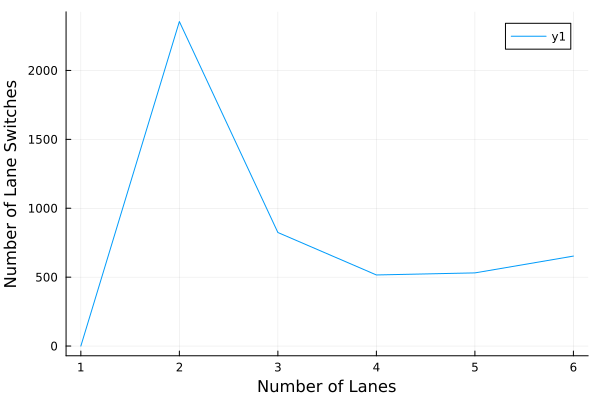

In [11]:
println(lane_switches)
plot(collect(1:1:6), lane_switches, xlabel="Number of Lanes", ylabel="Number of Lane Switches")

Any[101.0, 37.0, 31.0, 31.0, 31.0, 31.0]


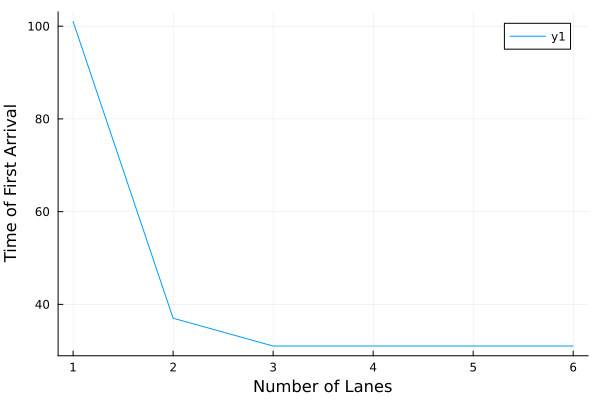

In [12]:
println(first_arrivals)
plot(collect(1:1:6), first_arrivals, xlabel="Number of Lanes", ylabel="Time of First Arrival")

Any[430.4, 346.0, 345.0, 345.0, 345.0, 345.0]


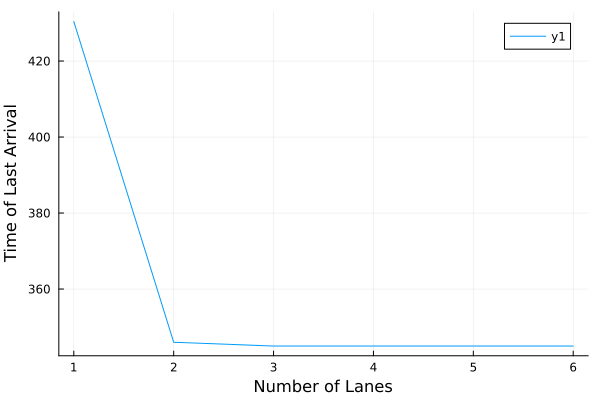

In [13]:
println(last_arrivals)
plot(collect(1:1:6), last_arrivals, xlabel="Number of Lanes", ylabel="Time of Last Arrival")

Random Car = 34
Any[324.0, 76.0, 58.0, 57.0, 57.0, 57.0]


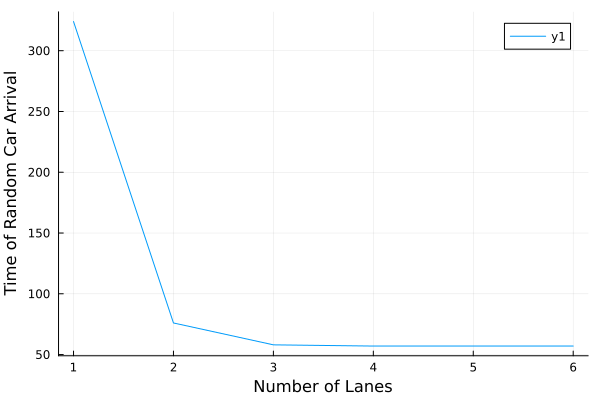

In [14]:
println("Random Car = ", rand_car)
println(rand_car_arrivals)
plot(collect(1:1:6), rand_car_arrivals, xlabel="Number of Lanes", ylabel="Time of Random Car Arrival")